# Veritas – Fine-Tuning Transformer Model for Fake News Detection

This notebook documents the end-to-end process of fine-tuning a transformer-based model (e.g., BERT) for binary classification: detecting whether a given text is a **real** or **fake** news item.

We use Hugging Face Transformers and Datasets libraries for efficient model training and evaluation.


**1.** Imports

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, DataCollatorWithPadding
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
from datasets import Dataset, DatasetDict
import kagglehub
import pandas as pd
import re
import torch
import string
import numpy as np
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**2.** Data loading

In [15]:
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
path += "/WELFake_Dataset.csv"

print("Path to dataset files:", path)
df = pd.read_csv(path, encoding="utf-8")
df.head()


Path to dataset files: /home/ptysiu/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77/WELFake_Dataset.csv


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


                                                text  labels label_names
0  No comment is expected from Barack Obama Membe...       1        real
1     Did they post their votes for Hillary already?       1        real
2   Now, most of the demonstrators gathered last ...       1        real
3  A dozen politically active pastors came here f...       0        fake
4  The RS-28 Sarmat missile, dubbed Satan 2, will...       1        real


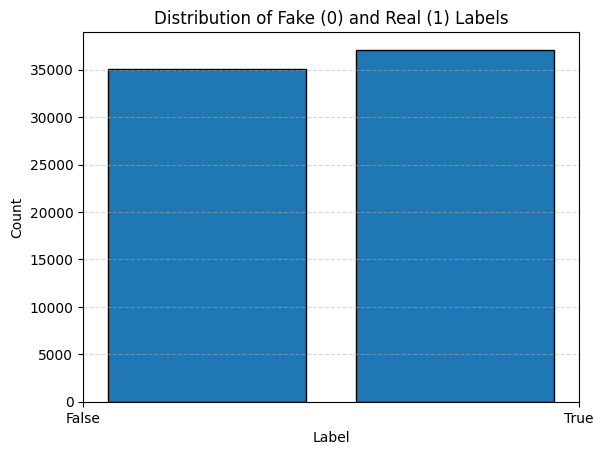

In [16]:
df.drop(columns=['title', 'Unnamed: 0'],axis=1,inplace=True)
df.rename(columns={'label':'labels'},inplace=True)
news_map = {1:'real',0:'fake'}
df['label_names'] = df['labels'].map(news_map)
values = df['labels']

print(df.head())

plt.hist(values, bins=2, edgecolor='black', rwidth=0.8)
plt.xticks([0, 1], ['False', 'True'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Fake (0) and Real (1) Labels")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


count     72134.000000
mean       3268.387834
std        3732.877545
min           0.000000
25%        1377.000000
50%        2424.000000
75%        4059.000000
max      142961.000000
Name: text_length, dtype: float64


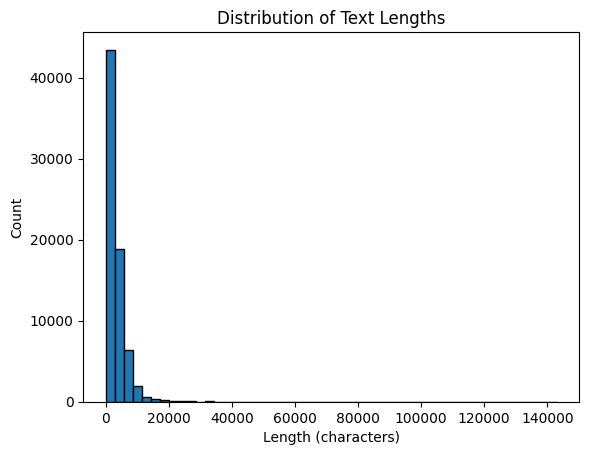

In [17]:
df['text_length'] = df['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

print(df['text_length'].describe())

plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Length (characters)")
plt.ylabel("Count")
plt.show()


In [18]:
# Cleaning the text - lowercase conversion, whitespace and special symbols deletion
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

df.dropna(axis=0,inplace=True)

df['text'] = df['text'].apply(clean_text)

df['text'].head()

0    no comment is expected from barack obama membe...
1        did they post their votes for hillary already
2     now most of the demonstrators gathered last n...
3    a dozen politically active pastors came here f...
4    the rs sarmat missile dubbed satan will replac...
Name: text, dtype: object

**3.** Tokenizing the data

In [19]:
# 3.1 Tokenizing

# Initialize the tokenizer
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Check vocabulary size
print(f"Vocabulary size: {len(tokenizer.vocab)}")
print(f"Tokenizer model max length: {tokenizer.model_max_length}")

# Perform train-test-validation split
train, test = train_test_split(df, test_size=0.3, stratify=df['labels'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['labels'])

print(train.shape, test.shape, validation.shape)

# Convert dataframe to dictionary
dataset = DatasetDict(
    {'train': Dataset.from_pandas(train, preserve_index=False),
     'test': Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)}
)

# Check dataset structure
print(dataset)

# Let's have a look at some entries
print(dataset['train'][0])
print(dataset['train'][1])
print(dataset['train'][2])

# 3.2 Tokenization Function¶

def tokenize_with_progress(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

# Add progress bar for tokenization
encoded_dataset = dataset.map(
    tokenize_with_progress,
    batched=True,
    batch_size=500,
    desc="Tokenizing"
)

# Check some tokenized outputs
print(encoded_dataset['train'][0])

# Poprawna wersja
labels = dataset['train'].unique('labels')
label_names = dataset['train'].unique('label_names')

label2id = {name: int(label) for name, label in zip(label_names, labels)}
id2label = {v: k for k, v in label2id.items()}


Vocabulary size: 30522
Tokenizer model max length: 512
(50466, 4) (14419, 4) (7210, 4)
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_names', 'text_length'],
        num_rows: 50466
    })
    test: Dataset({
        features: ['text', 'labels', 'label_names', 'text_length'],
        num_rows: 14419
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_names', 'text_length'],
        num_rows: 7210
    })
})
{'text': 'when allie mangel learned that she was losing some of her vision because of a rare condition called susac’s syndrome the last thing on her mind was figuring out how to make her car lease payments after her doctor notified the california department of motor vehicles last november that she should not be allowed to drive and her license was subsequently suspended leasing a ford edge at a month became an unnecessary expense or so she thought ms mangel a youth programming coordinator in san diego discovered that even thoug

Tokenizing: 100%|██████████| 7210/7210 [00:02<00:00, 2476.11 examples/s]

{'text': 'when allie mangel learned that she was losing some of her vision because of a rare condition called susac’s syndrome the last thing on her mind was figuring out how to make her car lease payments after her doctor notified the california department of motor vehicles last november that she should not be allowed to drive and her license was subsequently suspended leasing a ford edge at a month became an unnecessary expense or so she thought ms mangel a youth programming coordinator in san diego discovered that even though she was not legally allowed to drive she was still legally obligated to make her lease payments “ford credit and the dealer told me that the only way i could get out of the lease was to die or join the military” ms mangel said she had learned the hard way what many people may not realize even though leasing has become an increasingly common and seemingly affordable alternative to buying a car a car lease agreement is like any other contract and unless specific 

**4.** Model preparation

In [20]:
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules=["query", "key", "value", "dense"]
)

model = get_peft_model(model,peft_config)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
    }


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="none",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**5.** Fine-tuning

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipykernel_1973/40142889.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.149100,0.075350,0.979473,0.979476,0.979589,0.979473
2,0.059800,0.059600,0.984743,0.984741,0.984778,0.984743
3,0.043400,0.053486,0.987240,0.987240,0.987241,0.987240


TrainOutput(global_step=9465, training_loss=0.08408636464936609, metrics={'train_runtime': 12403.881, 'train_samples_per_second': 12.206, 'train_steps_per_second': 0.763, 'total_flos': 4.232697912093082e+16, 'train_loss': 0.08408636464936609, 'epoch': 3.0})

**6.** Evaluation

In [22]:
results = trainer.evaluate(encoded_dataset["test"])
print("Test set evaluation:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Test set evaluation:
eval_loss: 0.0511
eval_accuracy: 0.9875
eval_f1: 0.9875
eval_precision: 0.9875
eval_recall: 0.9875
eval_runtime: 658.0212
eval_samples_per_second: 21.9130
eval_steps_per_second: 0.6850
epoch: 3.0000


**7.** Analizing the Predictions

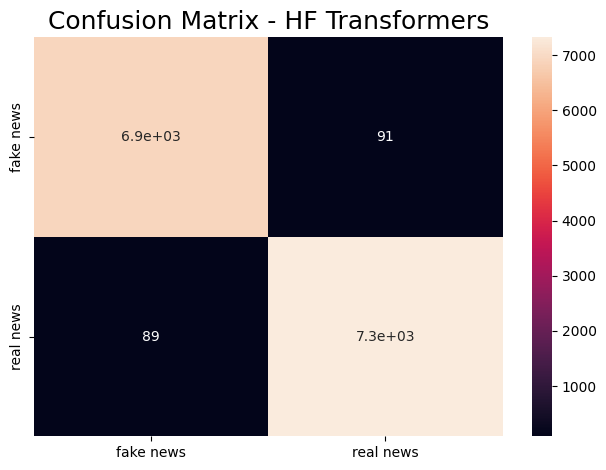

In [23]:
preds_output = trainer.predict(encoded_dataset['test'])

y_pred = np.argmax(preds_output.predictions,axis=1)

y_true = encoded_dataset['test'][:]['labels']

cm = confusion_matrix(y_true,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

**8.** Saving the model

In [24]:
model.save_pretrained("./model_directory")
tokenizer.save_pretrained("./model_directory")

('./model_directory/tokenizer_config.json',
 './model_directory/special_tokens_map.json',
 './model_directory/vocab.txt',
 './model_directory/added_tokens.json',
 './model_directory/tokenizer.json')

**9.** Conclusions

**Test Set Evaluation – Summary**

- **Accuracy:** 98.75%  
- **F1 Score:** 98.75%  
- **Precision:** 98.75%  
- **Recall:** 98.75%  
- **Loss:** 0.0511  

---

**Confusion Matrix Insights (HF Transformers)**

- **True Fake News (TN):** ~6900  
- **False Positives (FP):** 91  
- **False Negatives (FN):** 89  
- **True Real News (TP):** ~7300  

---

**Conclusions**

The model demonstrates **excellent performance** on the test set:

- **Very high precision and recall**, indicating a strong ability to distinguish between real and fake news.
- The **low number of misclassifications** (only 180 errors out of ~14,380 samples) confirms the model's **robustness and generalization**.
- Suitable for production use in misinformation detection, especially where high reliability is crucial.
